In [1]:
require "torch"
require "nn"
require "optim"
GITHUB=true

In [2]:
mean=0
var=1

-- tanító adatok generálása
function genDataSin(from, to, resolution, standardscale, random)
    random=random or false
    if (standardscale==nil) then standardscale=true end
    
    local dat=torch.Tensor()
    if (random==false) then
        -- egymás utáni értékek generálálsa
        dat = torch.Tensor(resolution):range(from,to):apply(math.rad)
    else
        -- véletlenszeru értékek generálása
        dat = torch.rand(resolution):mul(to):add(from):apply(math.rad)
    end
    local result=torch.cat(dat:clone(), dat:clone():apply(math.sin)*0.9,2)

    -- bemenet standardizálás
    if (standardscale==true) then
        print("Calculating mean and standard deviation....")
        mean=result[{{},1}]:mean()
        var=result[{{},1}]:std()
    end
    
    result[{{},1}]=(result[{{},1}]-mean)/var
    
    return result:clone()
end

In [3]:
-- modell létrehozása
function createModel(inputs, hiddens, outputs)
    local model = nn.Sequential();
    model:add(nn.Linear(inputs, hiddens[1]))
    model:add(nn.Tanh())

    if table.getn(hiddens)>1 then
        for i=1,table.getn(hiddens)-1 do 
            model:add(nn.Linear(hiddens[i], hiddens[i+1]))
            model:add(nn.Tanh())
        end
    end
    
    model:add(nn.Linear(hiddens[table.getn(hiddens)], outputs))
    model:add(nn.Tanh())

    return model
end

In [4]:
-- modell tanítása
function trainModel()
   params, gradParams = model:getParameters()
   local batchInputs = torch.Tensor(batchSize, data:size(2)-1)
   local batchLabels = torch.DoubleTensor(batchSize,1)
    
   for i = 1,epochs do
        local shuffle = torch.randperm(data:size(1))
        for k=1,data:size(1),batchSize do 
            l=1
            for j=k,math.min(k+batchSize-1,data:size(1)) do
            batchInputs[l] = data[{shuffle[j],{1,-2}}]
            batchLabels[l] = data[{shuffle[j],-1}]
            l=l+1
        end

        local function feval(params)
            gradParams:zero() -- korábbi gradiens kinullázása
            local outputs = model:forward(batchInputs) 
            local loss = criterion:forward(outputs, batchLabels) 
            local dloss_doutput = criterion:backward(outputs, batchLabels)
            model:backward(batchInputs, dloss_doutput)
            return loss,gradParams
        end
        _,loss = optim.sgd(feval, params, optimState)
        losses[i]=loss[1]
    end
    if i%100==0 then print(loss[1]) end
    end
end

In [5]:
epochs=500
batchSize=200
optimState = {
      learningRate = 0.05,
      weightDecay = 1e-4,
      momentum = 0.9,
      nesterov = false,
      dampering = 0,
      learningRateDecay = 0
    }

data=genDataSin(1,1000,1000)
criterion = nn.MSECriterion()
model=createModel(data:size(2)-1,{40,40},1)

if (batchSize>data:size(1)) then error() end 
losses = torch.Tensor(epochs)

print("Training started with batch size: " .. batchSize)
trainModel()
print("Training done.")

Calculating mean and standard deviation....	
Training started with batch size: 200	


0.3865729132343	


0.36309683796459	

0.190204119794	


0.05057080392479	


0.032654602972177	
Training done.	


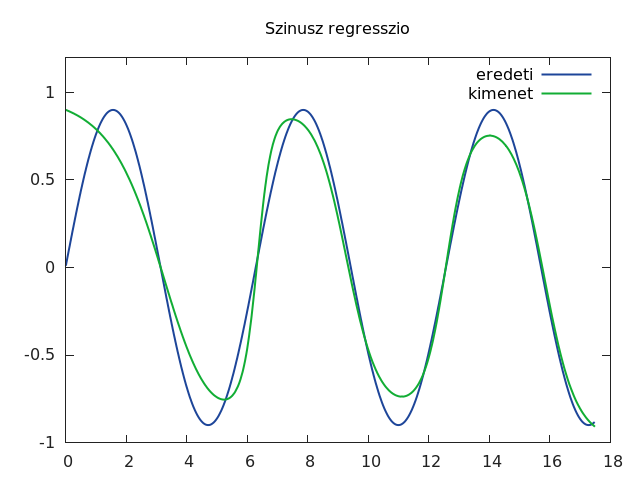

In [6]:
function plotSin(test_data,pred,git)
    local x1=data[{{},1}]:clone():mul(var):add(mean)
    local y1=data[{{},-1}]
    local x2=test_data[{{},1}]:clone():mul(var):add(mean)
    local y2=pred:reshape(pred:size(1))
    if git then
        require "gnuplot"
        gnuplot.pngfigure("plot.png")
        gnuplot.plot({"eredeti",x1,y1,"-"},
                     {"kimenet",x2,y2,"-"})
        gnuplot.title("Szinusz regresszio")
        gnuplot.axis({"","","",math.max(y1:max(),y2:max())+0.3})
        gnuplot.plotflush()
        local t0=os.clock()
        while ((os.clock()-t0)<3) do end
        itorch.image("plot.png")
        os.remove("plot.png")
    else
        local plot=itorch.Plot()
        plot:line(x1,y1,"blue","eredeti")
        plot:line(x2,y2,"green","kimenet")
        plot:title("Szinusz regresszio")
        plot:legend(true)
        plot:draw()
    end
end

local test_data=genDataSin(1,1000,1000,false,true)
local test_data=test_data:sort(1)
local pred=model:forward(test_data[{{},{1,-2}}])
plotSin(test_data,pred,GITHUB)

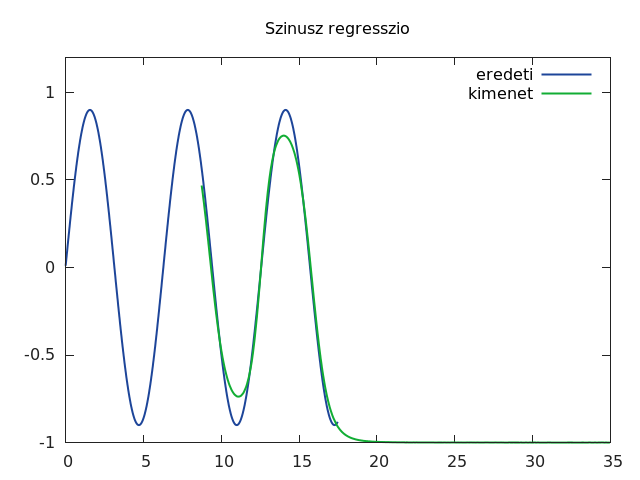

In [7]:
local test_data=genDataSin(500,1500,1000,false,true)
local test_data=test_data:sort(1)
local pred=model:forward(test_data[{{},{1,-2}}])
plotSin(test_data,pred,GITHUB)

In [8]:
function genDataSinFeedback(from, to, resolution, feedback, standardscale)
    if (standardscale==nil) then standardscale=true end
    local dat = torch.Tensor(resolution):range(from,to):apply(math.rad)
    local result=dat:clone()
    for i=1,feedback do 
        result=torch.cat(result:clone(), torch.cat(torch.Tensor(i):zero(),dat[{{i+1,-1}}]):clone():apply(math.sin)*0.9,2)
    end
    
    result=torch.cat(result:clone(), dat:clone():apply(math.sin)*0.9,2)
    -- bemenet standardizálás
    if (standardscale==true) then
        print("Calculating mean and standard deviation....")
        mean=result[{{},1}]:mean()
        var=result[{{},1}]:std()
    end
    
    result[{{},1}]=(result[{{},1}]-mean)/var
    return result:clone()
end
data=genDataSinFeedback(1,1000,1000,1)

Calculating mean and standard deviation....	


In [9]:
epochs=100
optimState = {
      learningRate = 0.05,
      weightDecay = 1e-4,
      momentum = 0.9,
      nesterov = false,
      dampering = 0,
      learningRateDecay = 0
    }

criterion = nn.MSECriterion()
model=createModel(data:size(2)-1,{40,40},1)

if (batchSize>data:size(1)) then error() end 
losses = torch.Tensor(epochs)

print("Training started with batch size: " .. batchSize)
trainModel()
print("Training done.")

Training started with batch size: 200	


0.0043613604364416	
Training done.	


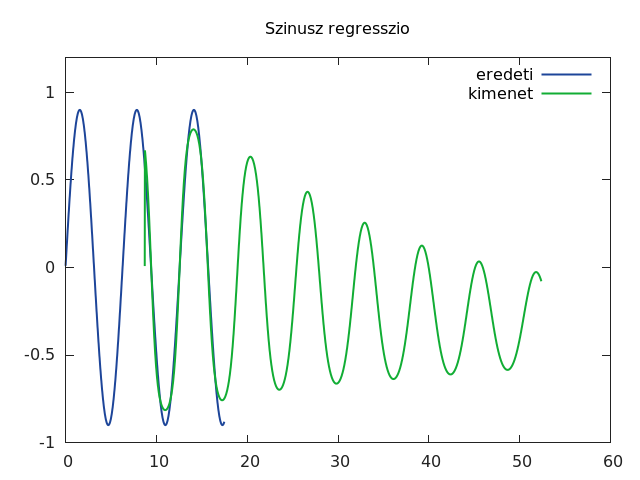

In [11]:
test_data=genDataSinFeedback(500,3000,1000,1,false)
--test_data=test_data:sort(1)
pred=model:forward(test_data[{{},{1,-2}}])
plotSin(test_data,pred,GITHUB)